# Neural networks basics

## 101

* Basics

https://towardsdatascience.com/comprehensive-introduction-to-neural-network-architecture-c08c6d8e5d98

## Theory and some math


*   Activation

https://towardsdatascience.com/7-popular-activation-functions-you-should-know-in-deep-learning-and-how-to-use-them-with-keras-and-27b4d838dfe6

* Loss

https://neptune.ai/blog/keras-loss-functions

* Epochs

https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9

* Optimization

https://towardsdatascience.com/neural-network-optimization-7ca72d4db3e0

https://machinelearningmastery.com/recommendations-for-deep-learning-neural-network-practitioners/

## Problems

* Why test/train splitting matters

https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

* Different image size

https://stackoverflow.com/questions/47929557/tensorflow-cnn-training-images-are-all-different-sizes

* Fitting epochs and batch size pars 

https://medium.com/@elimu.michael9/understanding-epochs-and-batches-23120a04b3cb


* **Why optimization = Adam?**




Adam is a combination of RMSprop and momentum (similarly, Nadam refers to a combination of RMSprop and Nesterov momentum). Adam refers to adaptive moment estimation, and it is the most popular optimizer used for neural networks today.

Adam computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients vt like Adadelta and RMSprop, Adam also keeps an exponentially decaying average of past gradients, similar to momentum.


# Imports

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import random
import itertools


from shutil import copyfile, rmtree
from pathlib import Path


from glob import glob

import os
# for dirname, _, filenames in os.walk('/kaggle/input/facial-age/face_age'):
#     print (dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix


# Dataset download

In [31]:
# remove and recreate dirs

!rm -rf /content/archives
!mkdir /content/archives
!rm -rf /content/raw_image_files
!mkdir /content/raw_image_files

In [29]:
dataset_main_dir = 'https://github.com/Somertonman/hackathon/raw/main/dataset/'

masks_archives = [
                  'mask_001_018.zip',
                  'mask_019_065.zip',
                  'mask_066_110.zip'
                  ]

In [ ]:
# download files

%%capture 
for arc in masks_archives:
  path = dataset_main_dir + arc
  !wget $path -O /content/archives/$arc

In [33]:
# unarchive to /content/raw_image_files

%%capture 
for arc in masks_archives:
  path = dataset_main_dir + arc
  !unzip -q /content/archives/$arc -d /content/raw_image_files

In [ ]:
INPUT_CLASSES_DIR = '/content/facial_age/'

folders = glob(INPUT_CLASSES_DIR + '*')

# Dataset analysis

In [ ]:
ages_dict = {}

for dirname in folders:
    ages_dict[dirname.rsplit('/')[-1]] = len(os.listdir(dirname))

print ('Possible ages:')
ages_dict = dict(sorted(ages_dict.items()))
print(ages_dict)

Possible ages:
{'001': 1112, '002': 475, '003': 284, '004': 260, '005': 180, '006': 114, '007': 126, '008': 236, '009': 159, '010': 140, '011': 63, '012': 106, '013': 75, '014': 137, '015': 143, '016': 212, '017': 103, '018': 181, '019': 58, '020': 103, '021': 136, '022': 139, '023': 92, '024': 191, '025': 156, '026': 279, '027': 126, '028': 145, '029': 150, '030': 109, '031': 97, '032': 141, '033': 46, '034': 87, '035': 121, '036': 112, '037': 94, '038': 91, '039': 136, '040': 85, '041': 56, '042': 84, '043': 52, '044': 27, '045': 77, '046': 61, '047': 70, '048': 64, '049': 99, '050': 105, '051': 62, '052': 133, '053': 133, '054': 106, '055': 52, '056': 132, '057': 60, '058': 96, '059': 59, '060': 137, '061': 50, '062': 76, '063': 47, '064': 29, '065': 113, '066': 54, '067': 47, '068': 58, '069': 45, '070': 53, '071': 22, '072': 70, '073': 31, '074': 16, '075': 87, '076': 35, '077': 19, '078': 30, '079': 16, '080': 71, '081': 10, '082': 29, '083': 7, '084': 11, '085': 130, '086': 22, 

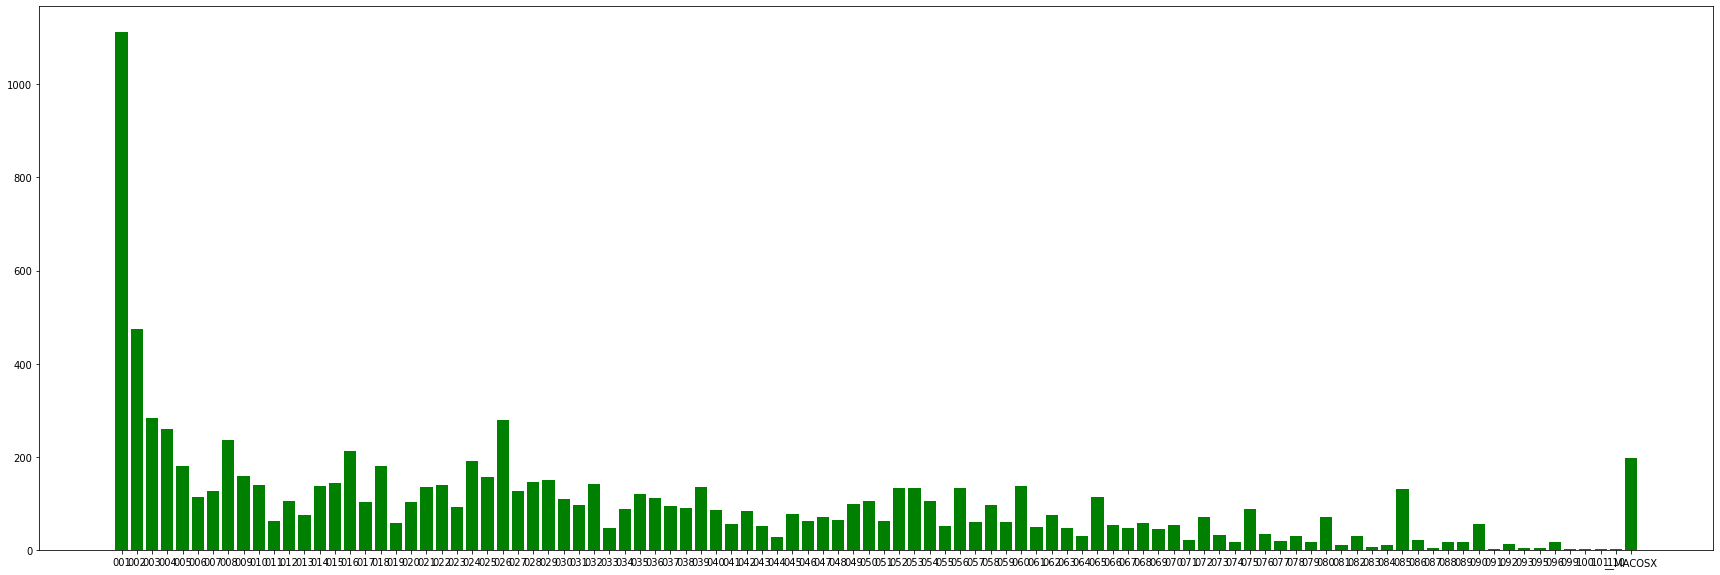

In [ ]:
plt.figure(figsize=(30, 10))

plt.bar(list(ages_dict.keys()), ages_dict.values(), color='g')

plt.show()


In [ ]:
sum(ages_dict.values())/len(ages_dict.values())

99.76

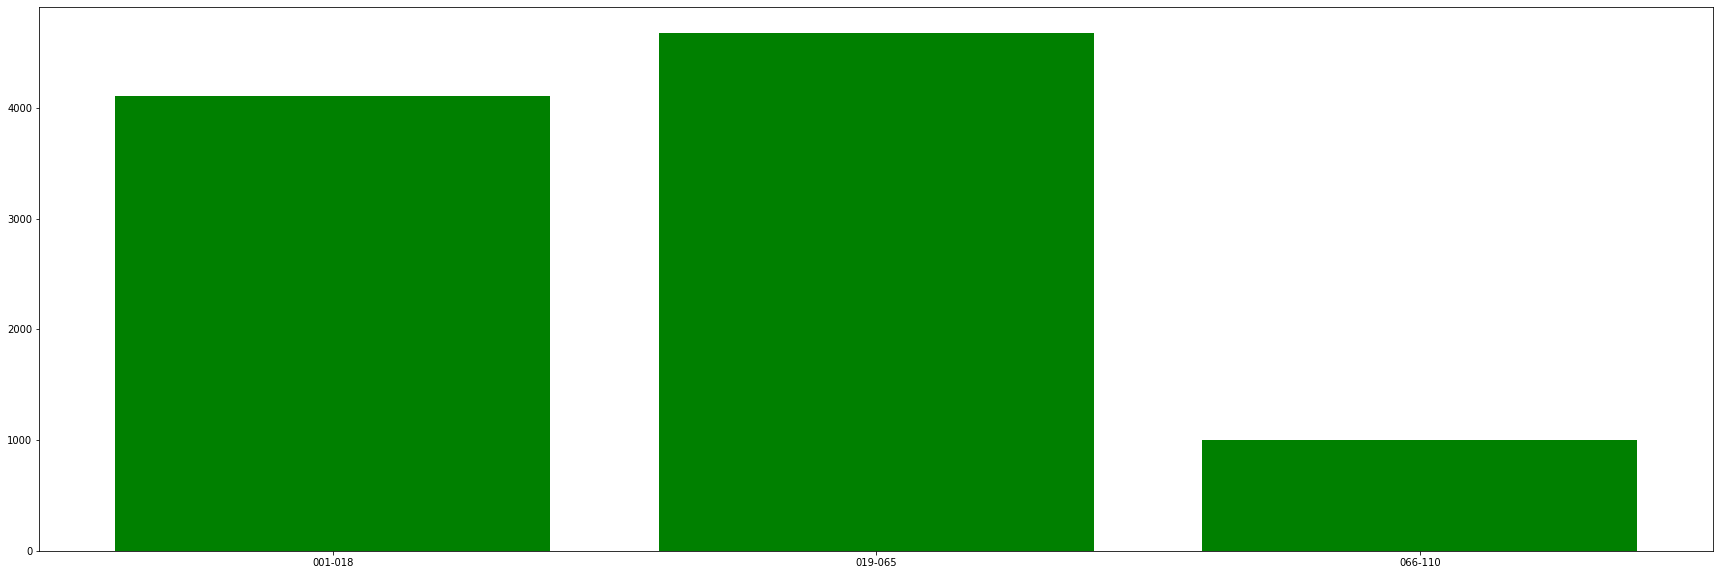

In [ ]:
age_splits = [1,19,66,111]

age_splits_ranges = [[str(x).rjust(3,"0") for x in list(range(age_splits[idx],age_splits[idx+1]))] for idx in range(len(age_splits)-1)]


age_groups = {}

for age_range in age_splits_ranges:
    total = 0
    for age in age_range:
        if age in ages_dict:
            total += ages_dict[age]
    age_groups[f'{age_range[0]}-{age_range[-1]}'] = total
    
#age_groups
plt.figure(figsize=(30, 10))

plt.bar(list(age_groups.keys()), age_groups.values(), color='g')

plt.show()


In [ ]:
age_groups

{'001-018': 4106, '019-065': 4674, '066-110': 998}

# Sampling and grouping to folders

In [ ]:
MIN_COUNT_IN_CLASS = min(age_groups.values())
MIN_COUNT_IN_CLASS = 100
TRAIN_SAMPLE_SIZE = int(MIN_COUNT_IN_CLASS * 0.85 )
TEST_SAMPLE_SIZE = MIN_COUNT_IN_CLASS - TRAIN_SAMPLE_SIZE

In [ ]:
test_root = './test'
train_root = './train'

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)

age_groupped_filenames_dict = {}

for age_range in age_splits_ranges:
    Path(f"{test_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    Path(f"{train_root}/{age_range[0]}-{age_range[-1]}").mkdir(parents=True, exist_ok=True)
    age_groupped_filenames = []
    for age in age_range:
        full_dirname = INPUT_CLASSES_DIR + age
        all_files_in_age_group = glob(full_dirname + '/*')
        if len(all_files_in_age_group) >=10:
          all_files_in_age_group = random.sample(all_files_in_age_group, 10)
        age_groupped_filenames.extend(all_files_in_age_group)
    age_groupped_filenames_dict[f'{age_range[0]}-{age_range[-1]}'] = age_groupped_filenames
    
for age_range in age_groupped_filenames_dict:
    age_sample = random.sample(age_groupped_filenames_dict[age_range], MIN_COUNT_IN_CLASS)
    train_filenames = age_sample[:TRAIN_SAMPLE_SIZE]
    for f in train_filenames:
        copyfile(f, f"{train_root}/{age_range}/{f.split('/')[-1]}")
        
    
    test_filenames = age_sample[TRAIN_SAMPLE_SIZE:]
    for f in test_filenames:
        copyfile(f, f"{test_root}/{age_range}/{f.split('/')[-1]}")

In [ ]:
# useful for getting number of files
train_files = glob(train_root + '/*/*.png')
test_files = glob(test_root + '/*/*.png')


In [ ]:
z = []


In [ ]:
print(len(train_files))
print(len(test_files))


255
45


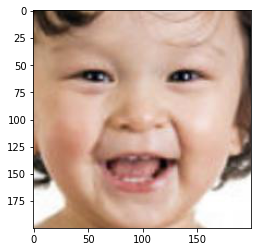

In [ ]:
plt.imshow(image.load_img(np.random.choice(train_files)))

In [ ]:
plt.imshow(image.load_img(np.random.choice(test_files)))


# Model set up

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [100, 100]

# training config:
epochs = 20
batch_size = 20


# resnet base
res = ResNet50(
input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in res.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x) # example
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=res.input, outputs=prediction)
# tell the model what cost and optimization method to use
model.compile(
loss='sparse_categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [ ]:
# get label mapping for confusion matrix plot
test_gen = val_gen.flow_from_directory(test_root, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 45 images belonging to 3 classes.
{'001-018': 0, '019-065': 1, '066-110': 2}


In [ ]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_root,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  test_root,
  target_size=IMAGE_SIZE,
  shuffle=False,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 255 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


# Training

In [ ]:
# fit the model
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(train_files) // batch_size,
  validation_steps=len(test_files) // batch_size,
)

# Training speed/quality

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
if 'val_loss' in r.history:
    plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
if 'val_accuracy' in r.history:
    plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

# Confusion matrix

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  n_images = 0
  for x, y in val_gen.flow_from_directory(
      data_path,
      target_size=IMAGE_SIZE,
      shuffle=False,
      batch_size=batch_size * 2):
    i += 1
    n_images += len(y)
    if i % 50 == 0:
      print(f'{n_images} images processed.')
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_root, len(train_files))
print(cm)
valid_cm = get_confusion_matrix(test_root, len(test_files))
print(valid_cm)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.figure(figsize=(30, 30))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')


# Save/load model

In [ ]:
#model.save('faces.h5')

#model = load_model('faces.h5')

# Testing with random images

In [ ]:
import requests, io, cv2
import numpy as np
from PIL import Image


In [ ]:
URL = 'https://image.shutterstock.com/image-photo/health-safety-pandemic-concept-portrait-260nw-1675058503.jpg'
response = requests.get(URL)
bytes_im = io.BytesIO(response.content)
cv_im = cv2.cvtColor(np.array(Image.open(bytes_im)), cv2.COLOR_RGB2BGR)

IMAGE_SIZE = (100,100)
internal_image = cv2.resize(cv_im,IMAGE_SIZE)
internal_image = internal_image.reshape(1,IMAGE_SIZE[0], IMAGE_SIZE[1],3) 


plt.imshow(internal_image[0])

In [ ]:
p = model.predict(internal_image)
p = np.argmax(p)
# pred_list = {x : float(y) for x,y in zip(labels, p[0])}
# pred_list
# pred_list = dict(sorted(pred_list.items(), reverse=True, key=lambda item: item[1]))
print('Predicted age group:', labels[p])